In [22]:
import sys, os
import numpy as np
from math import *
import math
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import auc

In [23]:
def bb_intersection_over_union(box1, box2):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(box1[0], box2[0])
	yA = max(box1[1], box2[1])
	xB = min(box1[2], box2[2])
	yB = min(box1[3], box2[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
	box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
	iou = interArea / float(box1Area + box2Area - interArea)
	return iou

In [24]:
#MTCNN
t = 0.5

MTCNN_precision_score=[]
MTCNN_recall_score=[]
MTCNN_false_positive=[]

confidence = np.linspace(0,1,num=1000,endpoint=False)
for c in confidence:
  print("c",c)

  TP=0
  FP=0
  precision_d=0
  recall_d=0

  folds = ["01","02","03","04","05","06","07","08","09","10"]
  for fold_num in folds:
    rect_filename = "/content/drive/MyDrive/paper_face_recognitioin/FDDB-folds/rect/FDDB-fold-{f_name}-rectList.txt".format(f_name = fold_num)
    pred_filename = "/content/drive/MyDrive/paper_face_recognitioin/FDDB-folds/confidence/MTCNN/FDDB-fold-{f_name}-MTCNN-confidence.txt".format(f_name = fold_num)
    with open(rect_filename) as f:
      rect_lines = [rect_line.rstrip('\n') for rect_line in f]
    with open(pred_filename) as p:
      pred_lines = [pred_line.rstrip('\n') for pred_line in p]

    gt_count = 0
    pred_count = 0
    while gt_count < len(rect_lines):
      gt_num = int(rect_lines[gt_count+1])
      #recall_d
      recall_d += gt_num

      #ground truths bounding boxes of the image
      gt_boxes=[]
      gt_state = np.zeros(gt_num, dtype = int)
      for i in range(gt_num):
        gt_boxes.append([int(g) for g in rect_lines[gt_count+i+2].split(",")])
      gt_box = [list(a) for a in zip(gt_boxes,gt_state)]
      #print(gt_box)

      #predicted boxes of the image
      pred_num = int(pred_lines[pred_count+1])
      pred_boxes = []
      pred_confidence = []
      for j in range(pred_num):
        elements = pred_lines[pred_count+j+2].split("/")
        pred_boxes.append([int(g) for g in elements[0].split(",")])
        pred_confidence.append(float(elements[1]))
      model_box = [list(b) for b in zip(pred_boxes,pred_confidence)]
      #print(model_box)

      for conf in pred_confidence:
        if conf >= c :
          #precision_d
          precision_d += 1

      #IOUs calculated for all predicted boxes with each ground truth bounding box
      if len(model_box) != 0:
        for boxB in model_box:
          if boxB[1] >= c :
            test_iou = []
            for boxA in gt_box:
              box_iou = (bb_intersection_over_union(boxA[0], boxB[0]))
              test_iou.append(box_iou)
          
            if max(test_iou) < t:
              FP += 1
              pass
            elif max(test_iou) >= t :
              max_index = test_iou.index(max(test_iou))
              if gt_box[max_index][1]==0:
                TP += 1
                gt_box[max_index][1]=1
              else:
                FP += 1
                    

      gt_count = gt_count + gt_num + 2
      pred_count = pred_count + pred_num + 2

  try:
    print("TP",TP)
    print("FP",FP)
    print("precision_d",precision_d)
    precision=TP/precision_d
    print("##precision:",precision)
    print("##recall:",recall)
  except:
    precision=0

  print("recall_d",recall_d)
  recall=TP/recall_d

  MTCNN_precision_score.append(precision)
  MTCNN_recall_score.append(recall)
  MTCNN_false_positive.append(FP)
print(MTCNN_precision_score)
print(MTCNN_recall_score)
print(MTCNN_false_positive)

Streaming output truncated to the last 5000 lines.
TP 3999
FP 165
precision_d 4164
##precision: 0.9603746397694525
##recall: 0.7733513827112745
recall_d 5171
c 0.28700000000000003
TP 3999
FP 165
precision_d 4164
##precision: 0.9603746397694525
##recall: 0.7733513827112745
recall_d 5171
c 0.28800000000000003
TP 3999
FP 165
precision_d 4164
##precision: 0.9603746397694525
##recall: 0.7733513827112745
recall_d 5171
c 0.289
TP 3999
FP 165
precision_d 4164
##precision: 0.9603746397694525
##recall: 0.7733513827112745
recall_d 5171
c 0.29
TP 3999
FP 165
precision_d 4164
##precision: 0.9603746397694525
##recall: 0.7733513827112745
recall_d 5171
c 0.291
TP 3999
FP 165
precision_d 4164
##precision: 0.9603746397694525
##recall: 0.7733513827112745
recall_d 5171
c 0.292
TP 3999
FP 165
precision_d 4164
##precision: 0.9603746397694525
##recall: 0.7733513827112745
recall_d 5171
c 0.293
TP 3999
FP 165
precision_d 4164
##precision: 0.9603746397694525
##recall: 0.7733513827112745
recall_d 5171
c 0.294
TP

In [25]:
interpolated_precision = 0
interpolation_range = np.arange(0,1.1,0.1)
for x in range(len(interpolation_range)-1):
  precision_range = []
  for i,r in enumerate(MTCNN_recall_score):
    if r>=interpolation_range[x] and r<interpolation_range[x+1]:
      precision_range.append(MTCNN_precision_score[i])
  if precision_range:
    interpolated_precision += max(precision_range)
AUC = interpolated_precision/11
print("AUC",AUC)

AUC 0.36072123931067474


Text(0, 0.5, 'Precision')

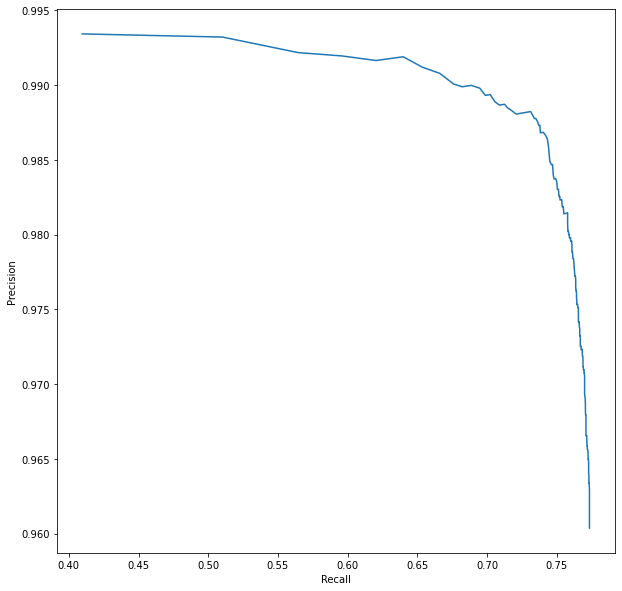

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(MTCNN_recall_score, MTCNN_precision_score, label='MTCNN')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

Text(0, 0.5, 'True Positive Rate')

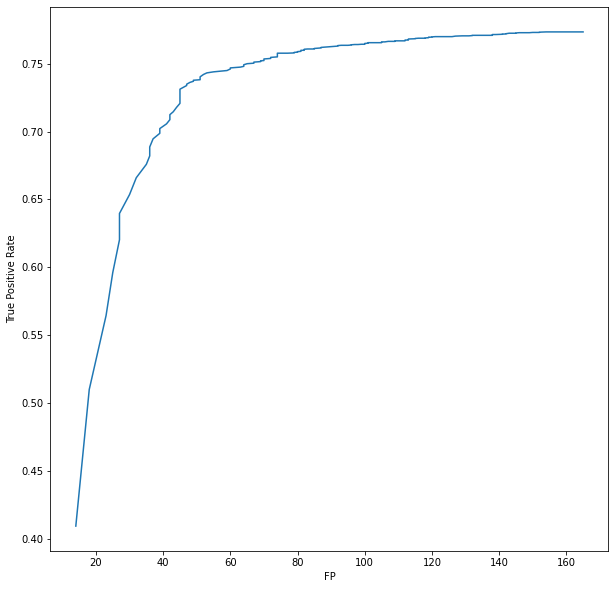

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(MTCNN_false_positive, MTCNN_recall_score, label='MTCNN')
ax.set_xlabel('FP')
ax.set_ylabel('True Positive Rate')

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
